In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np
import torch
from typing import Callable, Optional, Tuple, Type
import matplotlib.pyplot as plt

In [79]:
class BicycleModel:
    def __init__(self, dt : float = 0.05):
        self.dt = dt
        self.length = 3.0
        self.length_rear = 1.5

    def get_params(self) -> Tuple[float, float]:
        return self.length, self.length_rear

    def dynamics_ode(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """
        Compute the dynamics of the bicycle model x_dot = f(x, u). Supports batching.
    
        Args:
            x: (B,4) state [x, y, v, theta]
            u: (B,2) control input [a, delta]
        Returns:
            x_dot: (B,4) derivative of state
        """
        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))
        
        # Get batch size
        B = x.shape[0]
        
        # Get physical properties
        L, lr = self.get_params()

        # Get state and control
        pos_x, pos_y, v, theta = x[:,0], x[:,1], x[:,2], x[:,3]
        a, delta = u[:,0], u[:,1]

        # Equations of motion
        beta = torch.atan2(lr * torch.tan(delta), torch.tensor(L))

        pos_x_dot = v * torch.cos(theta + beta)
        pos_y_dot = v * torch.sin(theta + beta)
        v_dot = a
        theta_dot = v * torch.sin(beta) / lr

        x_dot = torch.zeros((B, 4))
        x_dot[:,0] = pos_x_dot
        x_dot[:,1] = pos_y_dot
        x_dot[:,2] = v_dot
        x_dot[:,3] = theta_dot

        return x_dot

    def integrate_dynamics(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """
        Computes x_t+1 = f(x_t, u_t) using rk4 on analytic dynamics model
        Supports batching.

        Args:
            x_t: (B,4) state [x, y, v, theta]
            u_t: (B,2) control input [a, delta]

        Returns:
            x_t+1: (B, 4) next state
        """
        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))

        k1 = self.dt * self.dynamics_ode(x, u)
        k2 = self.dt * self.dynamics_ode(x + k1 / 2, u)
        k3 = self.dt * self.dynamics_ode(x + k2 / 2, u)
        k4 = self.dt * self.dynamics_ode(x + k3, u)

        next_state = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # Wrap angles
        next_theta = torch.chunk(next_state, 4, dim=1)[3]
        next_theta_w = torch.atan2(torch.sin(next_theta), torch.cos(next_theta))
        next_state = torch.cat((next_state[:,:3], next_theta_w), dim=1)

        return next_state
    
    def eval_autograd_jacobian(self, x: torch.Tensor, u: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the continuous-time jacobians A and B at the given state and input using autograd on analytic dynamics

        Args:
            state: (1, 4) state [x, y, v, theta]
            control: (1, 2) control input [a, delta]

        Returns:
            A: (4, 4) process jacobian wrt state
            B: (4, 1) process jacobian wrt input 
        """
        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))

        # Linearize dynamics
        J = torch.autograd.functional.jacobian(self.dynamics_ode,(x, u))
        
        A = J[0].squeeze()
        B = J[1].squeeze()

        return A, B
    
    def eval_analytic_jacobian(self, x: torch.Tensor, u: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the continuous-time jacobians A, B at the given state and input analytically

        Args:
            x: (1, 4) state [x, y, v, theta]
            u: (1, 2) control input [a, delta]

        Returns:
            A: (4, 4) process jacobian wrt state
            B: (4, 2) process jacobian wrt input

        """
        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))

        # Get physical properties
        L, lr = self.get_params()

        # Get state and control
        pos_x, pos_y, v, theta = x[:,0], x[:,1], x[:,2], x[:,3]
        a, delta = u[:,0], u[:,1]

        # Linearize dynamics

        beta = torch.atan2(lr * torch.tan(delta), torch.tensor(L))

        A = torch.tensor([[0, 0, torch.cos(theta + beta), -v * torch.sin(theta + beta)],
                          [0, 0, torch.sin(theta + beta),  v * torch.cos(theta + beta)],
                          [0, 0, 0, 0],
                          [0, 0, torch.sin(beta)/lr, 0]])
        
        B = torch.tensor([[0, -lr/L * v * torch.sin(theta + beta) * torch.cos(beta)**2 * (1 + torch.tan(delta)**2)],
                          [0,  lr/L * v * torch.cos(theta + beta) * torch.cos(beta)**2 * (1 + torch.tan(delta)**2)],
                          [1, 0],
                          [0, v / L * torch.cos(beta)**3 * (1 + torch.tan(delta)**2)]])
        
        return A, B
    
    def discretize_linear_dynamics(self, A: torch.Tensor, B: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Discretize the linearized dynamics A, B using exact discretization
        
        Args:
            A: (4, 4) process jacobian wrt state
            B: (4, 2) process jacobian wrt input

        Returns:
            Ad: (4, 4) discrete-time process jacobian wrt state
            Bd: (4, 2) discrete-time process jacobian wrt input
        """
        T = self.dt

        Ad = torch.matrix_exp(A * self.dt)
        Bd = (T * torch.eye(4) + 1/2 * T**2 * A + 1/6 * T**3 * torch.matmul(A, A)) @ B

        rem = (T * torch.eye(4) + 1/2 * T**2 * A + 1/6 * T**3 * torch.matmul(A, A))
        return Ad, Bd, rem
    
    def discretize_dynamics(self, x: torch.Tensor, u: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Linearize and discretize the dynamics xdot = f(x, u) using exact discretization

        Args:
            x: (B,4) state [x, y, v, theta]
            u: (B,2) control input [a, delta]
        Returns:
            A_d: (4, 4) discrete-time process jacobian wrt state
            B_d: (4, 2) discrete-time process jacobian wrt input
        """


        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))

        # Get physical properties
        L, lr = self.get_params()
        T = self.dt

        # Get state and control
        pos_x, pos_y, v, theta = x[:,0], x[:,1], x[:,2], x[:,3]
        a, delta = u[:,0], u[:,1]

        beta = torch.atan2(lr * torch.tan(delta), torch.tensor(L))

        Ad = torch.tensor([[1, 0, T * torch.cos(theta + beta) - T**2/2 * v * torch.sin(beta) * torch.sin(beta + theta), -T * v * torch.sin(beta + theta)],
                           [0, 1, T * torch.sin(beta + theta) + T**2/2 * v * torch.sin(beta) * torch.cos(beta + theta),  T * v * torch.cos(beta + theta)],
                           [0, 0, 1, 0],
                           [0, 0, T / lr * torch.sin(beta), 1]])
        
        Bd = torch.tensor([[T**2/2 * torch.cos(beta + theta) - T**3/(6*lr) * v * torch.sin(beta) * torch.sin(beta + theta), -lr/L * T * v * torch.cos(beta)**2 * torch.sin(beta + theta) * (1 + torch.tan(delta)**2) - T**2/(2*L) * v**2 * torch.cos(beta)**3 * torch.sin(beta + theta) * (1 + torch.tan(delta)**2)],
                           [T**2/2 * torch.sin(beta + theta) + T**3/(6*lr) * v * torch.sin(beta) * torch.cos(beta + theta),  lr/L * T * v * torch.cos(beta)**2 * torch.cos(beta + theta) * (1 + torch.tan(delta)**2) + T**2/(2*L) * v**2 * torch.cos(beta)**3 * torch.cos(beta + theta) * (1 + torch.tan(delta)**2)],
                           [T, 0],
                           [T**2/(2*lr) * torch.sin(beta), T/L * v * torch.cos(beta)**3 * (1 + torch.tan(delta)**2)]])
        
        return Ad, Bd
    

    def discretize_dynamics2(self, x: torch.Tensor, u: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Linearize and discretize the dynamics xdot = f(x, u) using exact discretization

        Args:
            x: (B,4) state [x, y, v, theta]
            u: (B,2) control input [a, delta]
        Returns:
            A_d: (4, 4) discrete-time process jacobian wrt state
            B_d: (4, 2) discrete-time process jacobian wrt input
        """
        x = torch.reshape(x, (-1, 4))
        u = torch.reshape(u, (-1, 2))

        # Get physical properties
        L, lr = self.get_params()
        T = self.dt

        # Get state and control
        pos_x, pos_y, v, theta = x[:,0], x[:,1], x[:,2], x[:,3]
        a, delta = u[:,0], u[:,1]

        tan_delta = torch.tan(delta)
        tan_delta_dot = tan_delta**2+1
        
        beta = torch.arctan(lr * tan_delta / L) # I was using math.atan previously change it to math.atan if needed
        angle = theta + beta
        
        cos_beta= (L/torch.sqrt(L**2 + lr**2*tan_delta**2))

        A  =  torch.tensor([[0, 0, torch.cos(angle),                  -v*torch.sin(angle)],
                        [0, 0, torch.sin(angle),                   v*torch.cos(angle)],
                        [0, 0,       0,                                          0],
                        [0, 0, tan_delta*cos_beta/L,                  0 ]])
        B  = torch.tensor([[0, -(lr/L)*v*torch.sin(angle)*cos_beta**2*tan_delta_dot],
                       [0, (lr/L)*v*torch.cos(angle)*cos_beta**2*tan_delta_dot],
                       [1, 0],
                       [0, v*cos_beta**3*tan_delta_dot/L]])
        
        Ad = self.dt*A + torch.eye(4)
        Bd = self.dt*B        
        return Ad, Bd
    

In [80]:
bicycle = BicycleModel()

# Test the dynamics
x = torch.tensor([[0.2, 0.3, 0.8, 0.34],[0.5, 0.42, 0.8, 0.34]])
u = torch.tensor([[0.5, 0.42],[0.2, -0.42]])
x_dot = bicycle.dynamics_ode(x, u)
print(x_dot)
# x_dot2 = bicycle.dynamics_ode2(x, u)
# print(x_dot2)

# Test the dynamics
x = torch.tensor([[0.2, 0.3, 0.8, 0.34]])
u = torch.tensor([[0.5, 0.42]])
x_dot = bicycle.dynamics_ode(x, u)
print(x_dot)
# x_dot2 = bicycle.dynamics_ode2(x, u)
# print(x_dot2)

tensor([[ 0.6779,  0.4247,  0.5000,  0.1162],
        [ 0.7942,  0.0960,  0.2000, -0.1162]])
tensor([[0.6779, 0.4247, 0.5000, 0.1162]])


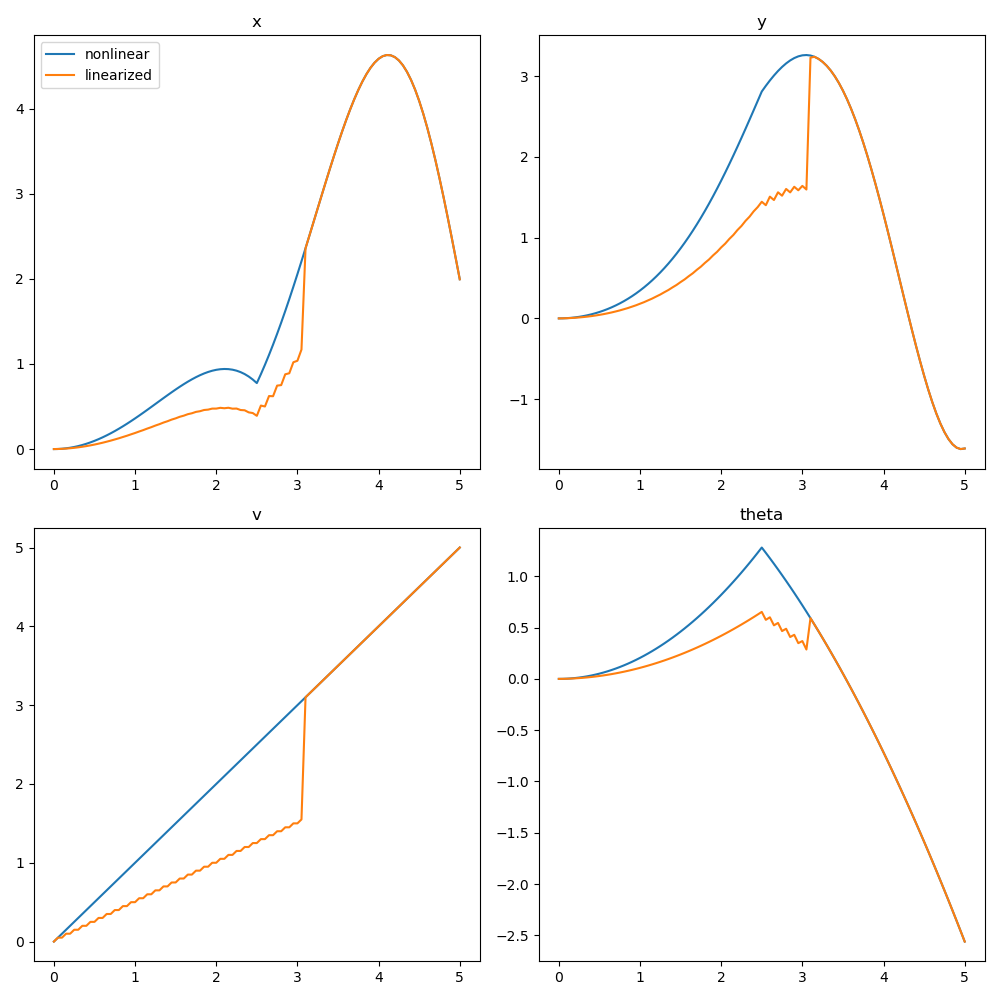

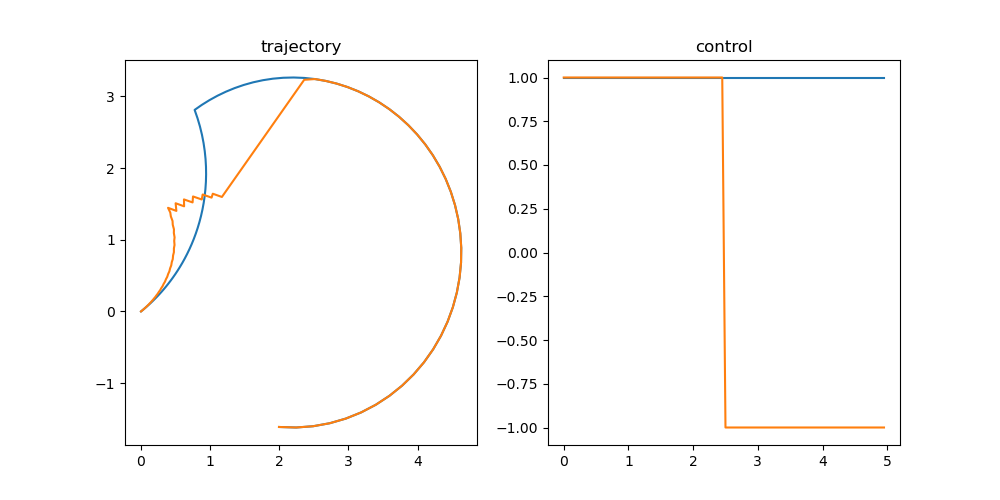

In [81]:
T=100
dt=0.05
# control_sequence = np.clip(0.4*np.random.randn(T, 2), -1, 1)
control_sequence = torch.ones((T, 2))
control_sequence[-int(T/2):,1]=-1.0

state = torch.zeros((T+1, 4))
state_linearized = torch.zeros((T+1, 4))

bicycle1 = BicycleModel()

for t in range(T):
    state[t + 1] = bicycle.integrate_dynamics(state[t], control_sequence[t])
    A, B = bicycle.eval_analytic_jacobian(state_linearized[t], control_sequence[t])
    Ad, Bd, rem = bicycle.discretize_linear_dynamics(A, B)
    f = bicycle.dynamics_ode(state_linearized[t], control_sequence[t]).reshape(-1, 1)

    # if unable to integrate accurately
    # state_linearized[t + 1] = (rem @ f + Ad @ (state[t]-state_linearized[t]).reshape(-1, 1)).reshape(4)

    # To check if we start off, how it goes with time
    if t <= 60:
        state_linearized[t + 1] = (rem @ f + Ad @ (state[t]-state_linearized[t]).reshape(-1, 1)).reshape(4)
    else:
        prime = bicycle.integrate_dynamics(state_linearized[t], control_sequence[t]).reshape(-1, 1)
        state_linearized[t + 1] = (prime + Ad @ (state[t]-state_linearized[t]).reshape(-1, 1)).reshape(4)
        # state_linearized[t + 1] = (prime).reshape(-1, 1).reshape(4) # just pure integration with wrong initial state at t=10

fig, ax = plt.subplots(2,2, figsize=(10,10))
t_vec = np.linspace(0, T*dt, T+1)

ax[0,0].plot(t_vec, state[:,0].detach().numpy(), label='nonlinear')
ax[0,0].plot(t_vec, state_linearized[:,0].detach().numpy(), label='linearized')
ax[0,0].set_title('x')
ax[0,1].plot(t_vec, state[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_linearized[:,1].detach().numpy())
ax[0,1].set_title('y')
ax[1,0].plot(t_vec, state[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_linearized[:,2].detach().numpy())
ax[1,0].set_title('v')
ax[1,1].plot(t_vec, state[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_linearized[:,3].detach().numpy())
ax[1,1].set_title('theta')
ax[0,0].legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(state[:,0].detach().numpy(), state[:,1].detach().numpy(), label='nonlinear')
ax[0].plot(state_linearized[:,0].detach().numpy(), state_linearized[:,1].detach().numpy(), label='linearized')
ax[0].set_title('trajectory')
ax[1].plot(t_vec[:-1], control_sequence.detach().numpy())
ax[1].set_title('control')
plt.show()


In [82]:
A_grad, B_grad = bicycle.eval_autograd_jacobian(state[5], control_sequence[5])
print(A_grad)
print(B_grad)

tensor([[ 0.0000,  0.0000,  0.7811, -0.1561],
        [ 0.0000,  0.0000,  0.6244,  0.1953],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4096,  0.0000]])
tensor([[ 0.0000, -0.1664],
        [ 0.0000,  0.2082],
        [ 1.0000,  0.0000],
        [ 0.0000,  0.1402]])


In [83]:
A , B = bicycle.eval_analytic_jacobian(state[5], control_sequence[5])
print(A)
print(B)

tensor([[ 0.0000,  0.0000,  0.7811, -0.1561],
        [ 0.0000,  0.0000,  0.6244,  0.1953],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4096,  0.0000]])
tensor([[ 0.0000, -0.1664],
        [ 0.0000,  0.2082],
        [ 1.0000,  0.0000],
        [ 0.0000,  0.1402]])


In [84]:
A_d1, B_d1, _ = bicycle.discretize_linear_dynamics(A, B)
print(A_d1)
print(B_d1)

tensor([[ 1.0000,  0.0000,  0.0390, -0.0078],
        [ 0.0000,  1.0000,  0.0313,  0.0098],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0205,  1.0000]])
tensor([[ 0.0010, -0.0083],
        [ 0.0008,  0.0104],
        [ 0.0500,  0.0000],
        [ 0.0005,  0.0070]])


In [85]:
A_d2, B_d2 = bicycle.discretize_dynamics(state[5], control_sequence[5])
print(A_d2)
print(B_d2)

tensor([[ 1.0000,  0.0000,  0.0389, -0.0078],
        [ 0.0000,  1.0000,  0.0314,  0.0098],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0205,  1.0000]])
tensor([[ 0.0010, -0.0083],
        [ 0.0008,  0.0104],
        [ 0.0500,  0.0000],
        [ 0.0005,  0.0070]])


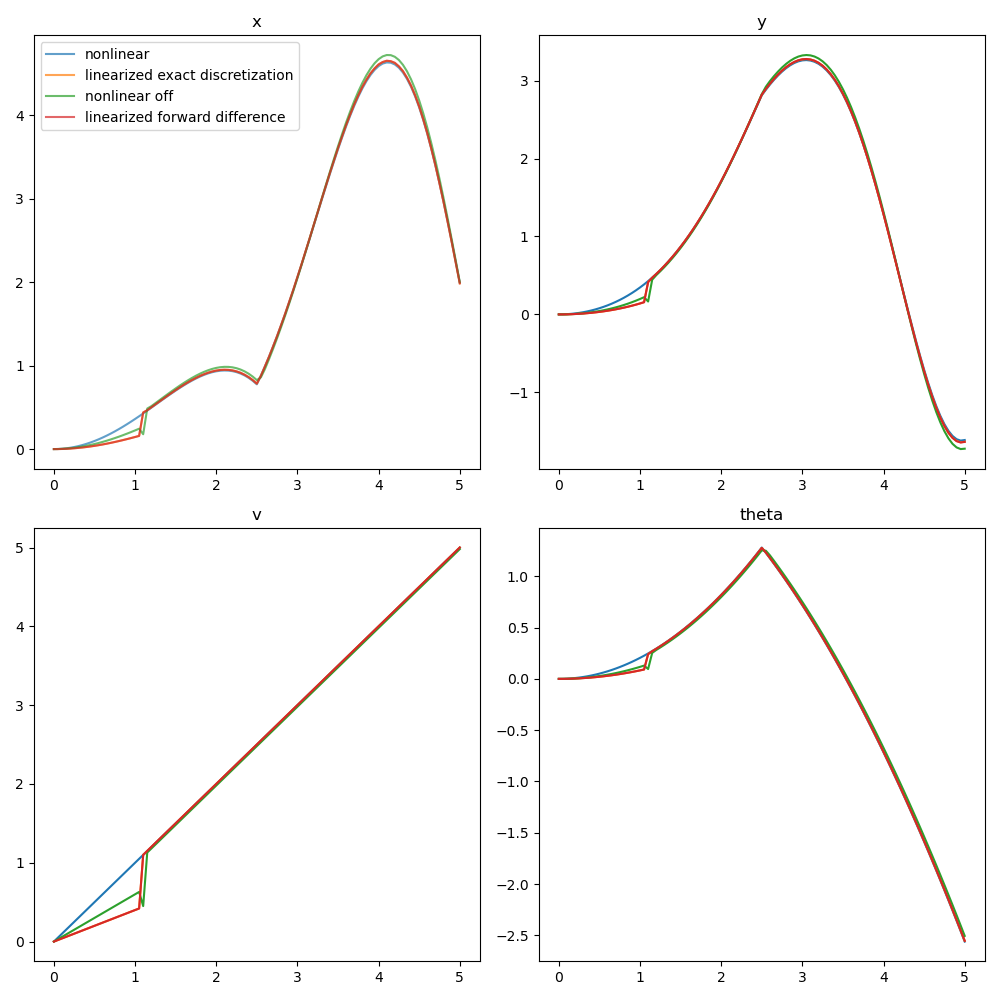

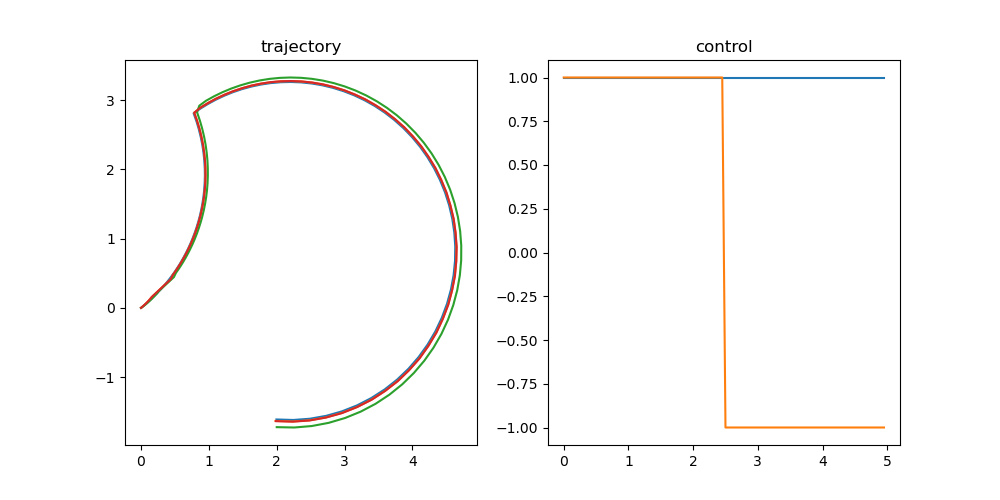

In [167]:
T=100
dt=0.05
control_sequence = torch.ones((T, 2))
control_sequence[-int(T/2):,1]=-1.0

state = torch.zeros((T+1, 4))
state_linearized = torch.zeros((T+1, 4))
state_linearized2 = torch.zeros((T+1, 4))
state_off = torch.zeros((T+1, 4))

bicycle1 = BicycleModel()

for t in range(T):
    # True value
    state[t + 1] = bicycle.integrate_dynamics(state[t], control_sequence[t])
    # Create an offset on purpose
    if t <= 20:
        # Off linearization point
        Ad, Bd = bicycle.discretize_dynamics(state[t]*0.6, control_sequence[t]*0.6)
        state_linearized[t + 1] = (Ad @ (state[t]*0.4).reshape(-1, 1) + Bd @ (control_sequence[t]*0.4).reshape(-1,1)).reshape(4)

        Ad2, Bd2 = bicycle.discretize_dynamics2(state[t]*0.6, control_sequence[t]*0.6)
        state_linearized2[t + 1] = (Ad2 @ (state[t]*0.4).reshape(-1, 1) + Bd2 @ (control_sequence[t]*0.4).reshape(-1,1)).reshape(4)

        prime = bicycle.integrate_dynamics(state[t]*0.6, control_sequence[t]*0.6).reshape(-1, 1)
        state_off[t + 1] = (prime).reshape(-1, 1).reshape(4)

    
    else:
        prime = bicycle.integrate_dynamics(state_linearized[t], control_sequence[t]*0.6).reshape(-1, 1)
        state_off[t + 1] = (prime).reshape(-1, 1).reshape(4) 

        Ad, Bd = bicycle.discretize_dynamics(state_linearized[t], control_sequence[t]*0.6)
        state_linearized[t + 1] = (prime + Ad @ (state[t]-state_linearized[t]).reshape(-1, 1) + Bd @ (control_sequence[t]*0.4).reshape(-1,1)).reshape(4)

        Ad2, Bd2 = bicycle.discretize_dynamics2(state_linearized2[t], control_sequence[t]*0.6)
        state_linearized2[t + 1] = (prime + Ad2 @ (state[t]-state_linearized2[t]).reshape(-1, 1) + Bd2 @ (control_sequence[t]*0.4).reshape(-1,1)).reshape(4)

    # print(Ad-Ad2)
    # print(Bd-Bd2)

fig, ax = plt.subplots(2,2, figsize=(10,10))
t_vec = np.linspace(0, T*dt, T+1)

ax[0,0].plot(t_vec, state[:,0].detach().numpy(), label='nonlinear', alpha = 0.7)
ax[0,0].plot(t_vec, state_linearized[:,0].detach().numpy(), label='linearized exact discretization', alpha = 0.7)
ax[0,0].plot(t_vec, state_off[:,0].detach().numpy(), label='nonlinear off', alpha = 0.7)
ax[0,0].plot(t_vec, state_linearized2[:,0].detach().numpy(), label='linearized forward difference', alpha = 0.7)
ax[0,0].set_title('x')
ax[0,1].plot(t_vec, state[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_linearized[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_off[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_linearized2[:,1].detach().numpy())
ax[0,1].set_title('y')
ax[1,0].plot(t_vec, state[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_linearized[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_off[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_linearized2[:,2].detach().numpy())
ax[1,0].set_title('v')
ax[1,1].plot(t_vec, state[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_linearized[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_off[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_linearized2[:,3].detach().numpy())
ax[1,1].set_title('theta')
ax[0,0].legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(state[:,0].detach().numpy(), state[:,1].detach().numpy(), label='nonlinear')
ax[0].plot(state_linearized[:,0].detach().numpy(), state_linearized[:,1].detach().numpy(), label='linearized')
ax[0].plot(state_off[:,0].detach().numpy(), state_off[:,1].detach().numpy(), label='fake')
ax[0].plot(state_linearized2[:,0].detach().numpy(), state_linearized2[:,1].detach().numpy(), label='linearized2')
ax[0].set_title('trajectory')
ax[1].plot(t_vec[:-1], control_sequence.detach().numpy())
ax[1].set_title('control')
plt.show()

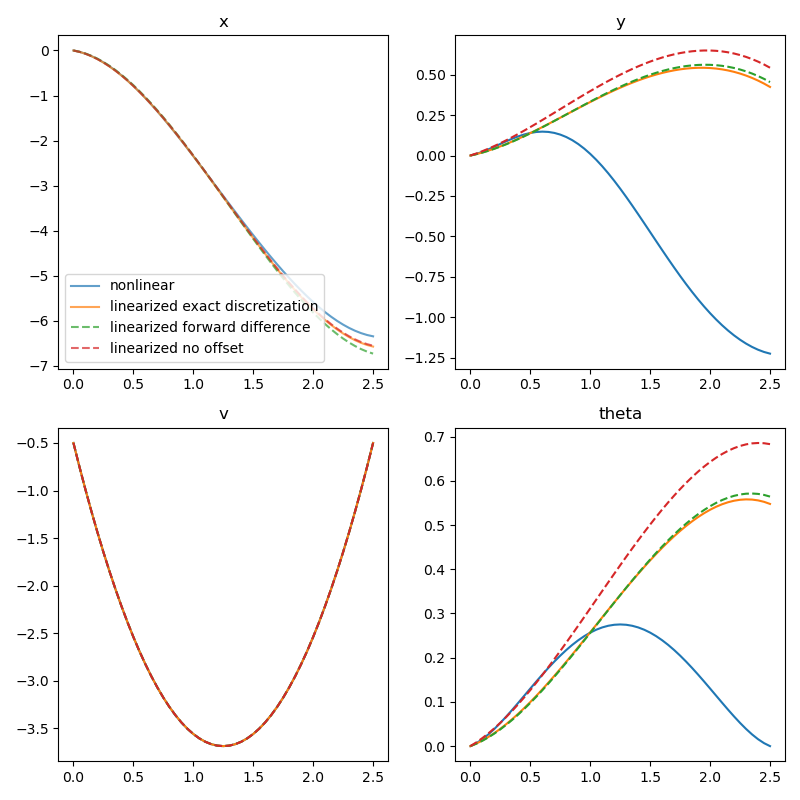

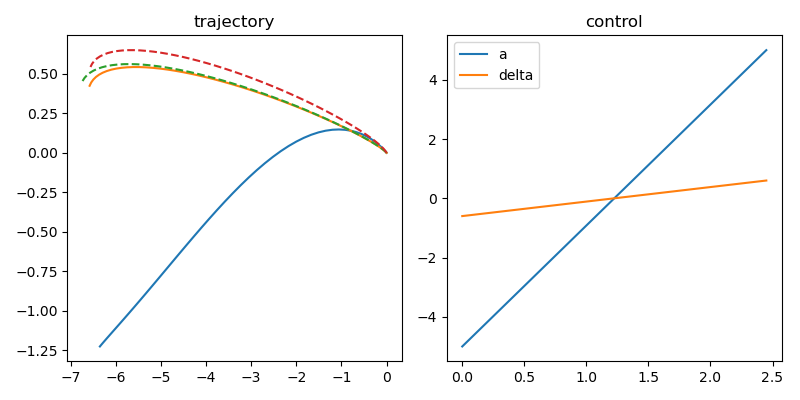

In [186]:
T=50
dt=0.05
control_sequence = torch.tensor([[5,0.6]])*torch.ones((T, 2)) * torch.tensor(np.array([[1],[1]])*np.linspace(-1, 1, T)).T
control_sequence = control_sequence.float()
# control_sequence = torch.ones((T, 2))
# control_sequence[-int(T/2):,1]=-1.0

state = torch.zeros((T+1, 4))
state_linearized = torch.zeros((T+1, 4))
state_linearized2 = torch.zeros((T+1, 4))
state_lin_no_off = torch.zeros((T+1, 4))

bicycle = BicycleModel()

# Get to some nonzero state
for t in range(21):
    state[t + 1] = bicycle.integrate_dynamics(state[t], control_sequence[t])

state_0 = torch.tensor([0,0,-0.5,0])#state[20]#torch.tensor([0,0,0.5,0])#state[0]  
state_linearized[0] = state_0
state_linearized2[0] = state_0
state_lin_no_off[0] = state_0
state = torch.zeros((T+1, 4))
state[0] = state_linearized[0]

Ad, Bd = bicycle.discretize_dynamics(state[0], control_sequence[12])
Ad2, Bd2 = bicycle.discretize_dynamics2(state[0], control_sequence[12])
prime = bicycle.integrate_dynamics(state[0], control_sequence[12]).reshape(-1, 1)

for t in range(T):
    # True value
    state[t + 1] = bicycle.integrate_dynamics(state[t], control_sequence[t])

    state_linearized[t + 1] = (prime + Ad @ (state_linearized[t]-state[0]).reshape(-1, 1) + Bd @ (control_sequence[t]-control_sequence[12]).reshape(-1,1)).reshape(4)

    state_linearized2[t + 1] = (prime + Ad2 @ (state_linearized2[t]-state[0]).reshape(-1, 1) + Bd2 @ (control_sequence[t]-control_sequence[12]).reshape(-1,1)).reshape(4)

    state_lin_no_off[t + 1] = (Ad @ (state_lin_no_off[t]).reshape(-1, 1) + Bd @ (control_sequence[t]).reshape(-1,1)).reshape(4)

fig, ax = plt.subplots(2,2, figsize=(8,8))
t_vec = np.linspace(0, T*dt, T+1)

ax[0,0].plot(t_vec, state[:,0].detach().numpy(), label='nonlinear', alpha = 0.7)
ax[0,0].plot(t_vec, state_linearized[:,0].detach().numpy(), label='linearized exact discretization', alpha = 0.7)
ax[0,0].plot(t_vec, state_linearized2[:,0].detach().numpy(),'--', label='linearized forward difference', alpha = 0.7)
ax[0,0].plot(t_vec, state_lin_no_off[:,0].detach().numpy(),'--', label='linearized no offset', alpha = 0.7)
ax[0,0].set_title('x')
ax[0,1].plot(t_vec, state[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_linearized[:,1].detach().numpy())
ax[0,1].plot(t_vec, state_linearized2[:,1].detach().numpy(),'--')
ax[0,1].plot(t_vec, state_lin_no_off[:,1].detach().numpy(),'--')
ax[0,1].set_title('y')
ax[1,0].plot(t_vec, state[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_linearized[:,2].detach().numpy())
ax[1,0].plot(t_vec, state_linearized2[:,2].detach().numpy(),'--')
ax[1,0].plot(t_vec, state_lin_no_off[:,2].detach().numpy(),'--')
ax[1,0].set_title('v')
ax[1,1].plot(t_vec, state[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_linearized[:,3].detach().numpy())
ax[1,1].plot(t_vec, state_linearized2[:,3].detach().numpy(),'--')
ax[1,1].plot(t_vec, state_lin_no_off[:,3].detach().numpy(),'--')
ax[1,1].set_title('theta')
ax[0,0].legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(state[:,0].detach().numpy(), state[:,1].detach().numpy(), label='nonlinear')
ax[0].plot(state_linearized[:,0].detach().numpy(), state_linearized[:,1].detach().numpy(), label='linearized')
ax[0].plot(state_linearized2[:,0].detach().numpy(), state_linearized2[:,1].detach().numpy(),'--', label='linearized2')
ax[0].plot(state_lin_no_off[:,0].detach().numpy(), state_lin_no_off[:,1].detach().numpy(),'--', label='linearized no offset')
ax[0].set_title('trajectory')
ax[1].plot(t_vec[:-1], control_sequence[:,0].detach().numpy(), label='a')
ax[1].plot(t_vec[:-1], control_sequence[:,1].detach().numpy(), label='delta')
ax[1].legend()
ax[1].set_title('control')
fig.tight_layout()
plt.show()

In [88]:
bicycle.integrate_dynamics(torch.zeros(1,4), torch.zeros(1,2))

tensor([[0., 0., 0., 0.]])

In [113]:
A, B = bicycle.discretize_dynamics(torch.zeros([1,4]), torch.zeros([1,2]))
print(A)
print(B)

A, B = bicycle.discretize_dynamics(torch.tensor([[0,0,0.1,0]]), torch.zeros([1,2]))
print(A)
print(B)

A, B = bicycle.discretize_dynamics(torch.tensor([[0,0,0.1,0]]), torch.tensor([[-10.0,0.0]]))
print(A)
print(B)

tensor([[1.0000, 0.0000, 0.0500, -0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor([[0.0012, -0.0000],
        [0.0000, 0.0000],
        [0.0500, 0.0000],
        [0.0000, 0.0000]])
tensor([[1.0000, 0.0000, 0.0500, -0.0000],
        [0.0000, 1.0000, 0.0000, 0.0050],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor([[0.0012, -0.0000],
        [0.0000, 0.0025],
        [0.0500, 0.0000],
        [0.0000, 0.0017]])
tensor([[1.0000, 0.0000, 0.0500, -0.0000],
        [0.0000, 1.0000, 0.0000, 0.0050],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
tensor([[0.0012, -0.0000],
        [0.0000, 0.0025],
        [0.0500, 0.0000],
        [0.0000, 0.0017]])


In [159]:
integ = bicycle.integrate_dynamics(torch.tensor([0,2.5,0.1,0]), torch.zeros(1,2))
print(integ)
a,b=bicycle.eval_analytic_jacobian(torch.tensor([[0,2.5,0.1,0]]), torch.zeros(1,2))
ad,bd,rem = bicycle.discretize_linear_dynamics(a,b)
f = bicycle.dynamics_ode(torch.tensor([[0,2.5,0.1,0]]), torch.zeros(1,2)).reshape(-1, 1)
print((rem@f).T)

tensor([[0.0050, 2.5000, 0.1000, 0.0000]])
tensor([[0.0050, 0.0000, 0.0000, 0.0000]])


In [160]:
print(integ.T)
print(ad@torch.tensor([[0,2.5,1.0,0.0]]).T)

tensor([[0.0050],
        [2.5000],
        [0.1000],
        [0.0000]])
tensor([[0.0500],
        [2.5000],
        [1.0000],
        [0.0000]])


In [161]:
integ.T+ad@(torch.tensor([[0,2.5,-10,0.8]])-torch.tensor([[0,2.5,0.1,0]])).T

tensor([[ -0.5000],
        [  2.5040],
        [-10.0000],
        [  0.8000]])

In [162]:
ad@(torch.tensor([[0,2.5,-10,0.8]])).T

tensor([[ -0.5000],
        [  2.5040],
        [-10.0000],
        [  0.8000]])

In [163]:
bd@(torch.tensor([[0.0,0.0]]).T)

tensor([[0.],
        [0.],
        [0.],
        [0.]])